# Food Vision Project

## Introduction

**Food Vision** is classification-based project which is able to classify 101 classes of [food101](https://www.kaggle.com/datasets/dansbecker/food-101) dataset.

To get better results and to save time, **transfer learning** is used to train the model for this project. **EfficientNet-B2** that was trained on [ImageNet Dataset](https://www.image-net.org/) architecure was used as a **feature extractor** for the model.

***But why use this architecture?***

**EfficientNet-V2M** could've also been considered but it wasn't chosen for several reasons. The **Google Colaboratory's GPU *Tesla T4*** was used for this project. Although, this wasn't a very low-end GPU but when training a model with larger parameters, having just one won't suffice. So, the following requirements were taken under consideration when choosing the architecture:

*   Lower Depth *(Faster Gradient Descent)*.
*   Higher the ratio `accuracy / no. of parameters` , the better *(Faster Training Epochs)*.
*   The model's predecessors have proven to show good results on the considered dataset.

The **EfficientNet-B2** architecture, for this use-case becomes more efficient when training on single/low-end GPUs. This means that the `Top-1 Accuracy of 80.1` shown on **imagenet dataset** is better with just `9.2M parameters` when compared to other models when considering the above requirements.

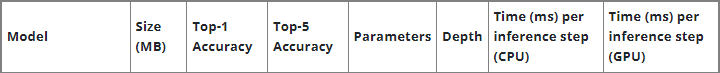
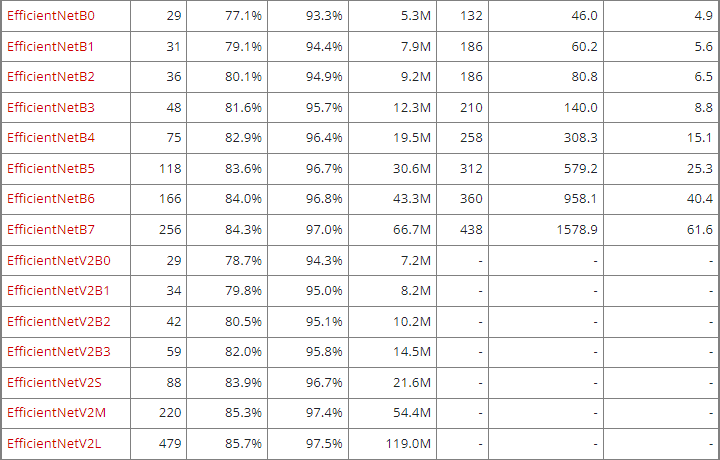

**What will be covered?**

*   Importing **food101** dataset
*   Preprocessing the data
*   Using TensorFlow to prepare the dataset
*   Exploring the data
*   Creating model callbacks
*   Importing EfficientNet-B2 architecture for transfer learning
*   Fine-Tuning the model
*   Experimenting with Data Augmentation
*   Evaluating the model (Finding our model's most wrong predictions)
*   Making predictions with our Food Vision model on custom images of food

## Importing Essential Libraries

In [ ]:
# check GPU
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


In [1]:
# Import essential libraries
from datetime import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score

It is still rather questionable whether we will be able to use **mixed precision** for this project because only **Tesla T4** GPU *(in Google Colab)* has the *7.0+ compute compability score* which isn't easy to get in most instances.

In [ ]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.2


## Importing the **food101** Dataset

There are multiple resources to get the food101 dataset like mentioned above was the kaggle resource but that will have a few extra steps to get it up and ready to be used in this project.

Instead, [TensorFlow Datasets](https://www.tensorflow.org/datasets) is used for the following reasons.
*    Ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks
*    Comes pre-loaded in tensors
*    Able to handle various methods to manipulate/preprocess the datasets
*    Splitting the datasets in to train/dev sets has never been easier
*    Efficient for experimenting because of its static nature

In [2]:
# Import the food101 dataset
(train_dataset, dev_dataset), ds_info = tfds.load(
                                          "food101",
                                          split=["train", "validation"],
                                          shuffle_files=False,
                                          as_supervised=True,   # tuple-format (image tensors, label)
                                          with_info=True  # metadata
                                          )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteQJDHDP/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteQJDHDP/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


The dataset got split-up in **75% train_dataset** for training and **25% dev_dataset** for validation purposes.

In [ ]:
# number of classes in the datasete
print(f"Number of Classes in the dataset are {len(ds_info.features["label"].names)}")

In [ ]:
# meta-data for the food101 dataset
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})


In [4]:
# Classes in the dataset
class_names = ds_info.features["label"].names
print(f"First five classes of dataset are: {class_names[:5]}")

First five classes of dataset are: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']


`ds_info.features["label"].name` provides a list of classes names which count-up to expected number of 101.

## Preprocessing the Data

The data needs to be preprocessed for training. This is an essential process for the following reasons:
*    It makes the data easier to interpret and use for the architecture under use.
*    Sometimes data preprocessing might reduce the training time.
*    Cleaning the data and making it suitable for a machine learning model which also increases the accuracy and efficiency of a machine learning model.

In [5]:
def preprocess_img(image, label, shape=300):
    """Resizes and converts the image along with its label
    Returns ``[img_shape, shape, channels]``

    Parameters:
    -----------
    image: uint8
    label: int
    """
    image = tf.cast(tf.image.resize(image, [shape, shape]), tf.float32)
    return image, label   # returns a tuple ``(image, label)``

### Preparing the Training Dataset

Preparing a large training dataset like in this case **food101** has to be prepared in *batches* before it is ready for training as it is more memory efficient.

Though necessary, batching isn't the only options available to effectively use the datasets. The [tf.data.Dataset](tensorflow.org/api_docs/python/tf/data/Dataset) has many methods that can, not only help speed-up the training but can also parallelize the operations *like **preparing (CPU)** and **training (GPU)** with the training batches at the same time*.

The methods that will be used in this project are as follows:
*   **map()**: This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input. map_func can be used to change both the values and the structure of a dataset's elements. *i.e `preprocess_img` function in our case.*

*   **shuffle()**: Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. *For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required. But due to memory constraints, it is best to shuffle the dataset in batches.*

*   **batch()**: Combines consecutive elements of this dataset into batches that is memory efficient. *Typically a **batch of 32 (base 2 to the power 5 or greater)** is preferred.*

*   **prefetch()**: Creates a Dataset that prefetches elements from this dataset. Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. *This often improves latency and throughput, at the cost of using additional memory to store prefetched elements which significantly speeds-up the training process as it improves data loading speed at the cost of memory.*

*   **cache()**: Caches the elements in this dataset onto the memory for faster loading and training which reduces the time required for GPU to get a new batch for training helping speeding-up the process as a whole. *But we can't perform this step as the dataset won't be able to fit into the memory.*

A few aditional considerations are as follows:
* For this model, we will be using `batch_size` of **32** *(can be subjected to change depending on the results)*.
* `tf.data.AUTOTUNE` will be used where necessary to parallelize preprocessing and significantly improve speed.
* `buffer_size` will be kept to the ***100th of the total examples*** in the training dataset.

In [6]:
# create a optimized data pipeline
BATCH_SIZE = 32
# for train_dataset
train_dataset = train_dataset.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).\
                          shuffle(buffer_size=len(train_dataset)//50).\
                          batch(BATCH_SIZE).\
                          prefetch(buffer_size=tf.data.AUTOTUNE)

# for dev_dataset
# won't need shuffling for our dev_dataset as it will create some unwanted problems during the model evaluation
dev_dataset = dev_dataset.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).\
                          batch(BATCH_SIZE).\
                          prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Exploration

In [ ]:
# funtion to explore the dataset
def show_img_from_optimized_dataset(dataset=train_dataset):
    """Displays Image from the dataset along with its information.
    Returns a random image from the dataset along with its metadata.

    Parameters:
    -----------
    dataset: tensorflow_dataset
        loaded dataset that is a tuple `(None, images, labels)` with image being (Batch, Height, Width, Channels)
    """

    sample = [*dataset.take(1)][0]
    image, label = sample[0][0], sample[1][0]
    class_names = ds_info.features["label"].names

    plt.imshow(tf.cast(image, "uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis('off')
    plt.show()

    img_info = print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    Lowest tensor value in the image: {tf.reduce_min(image)}
    Highest tensor value image: {tf.reduce_max(image)}
    """
          )
    return img_info

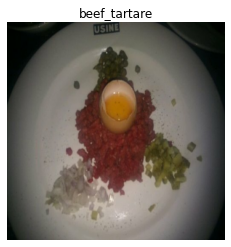


    Image shape: (300, 300, 3)
    Image dtype: <dtype: 'float32'>
    Target class from Food101 (tensor form): 4
    Class name (str form): beef_tartare
    Lowest tensor value in the image: 0.0
    Highest tensor value image: 255.0
    


In [ ]:
# explore the training dataset to check whether everything is as expected
show_img_from_optimized_dataset()

## Setting up Mixed Precision (Optional)

According to the [article](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#:~:text=Since%20the%20introduction%20of%20Tensor,most%20arithmetically%20intense%20model%20architectures.): *Since the introduction of Tensor Cores in the Volta and Turing architectures, significant training speedups are experienced by switching to mixed precision -- up to 3x overall speedup on the most arithmetically intense model architectures.*

Usually, tensors in ***TensorFlow*** exist as `tf.float32` by default. But involving mixed-precision will introduce the use of `tf.float16` along with `tf.float32` when training the model. **Mixed precision** is the use of both **16-bit** and **32-bit** floating-point types in a model during training to make it run faster and use less memory. By keeping certain parts of the model in the **32-bit types** for numeric stability, the model will have a lower step time and train equally as well in terms of the evaluation metrics such as accuracy.

Today, **most models use the float32 dtype, which takes 32 bits of memory**. Modern accelerators can run operations **faster in the 16-bit dtypes**, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

**NVIDIA GPUs** can run operations in **float16** faster than in float32, and TPUs can run operations in bfloat16 faster than float32. Therefore, these lower-precision dtypes should be used whenever possible on those devices.


**⚠ Warning:**
Mixed-Precision also comes with a nuance, i.e, it only works with the **GPUs having a compute capability score of 7.0+** and that is one serious issue when training models in **Google Colab**. Google Colab usually provides **K80** and **Tesla T4** but only ***Tesla T4 has the 7.0 compute capability score***. So, it needs to be taken under consideration before using mixed precision training.

In [ ]:
# set-up mixed precision and check the GPU compatibilty
mixed_precision.set_global_policy(policy="mixed_float16")

if '<Policy "mixed_float16">' == str(mixed_precision.global_policy()):
    print("GPU is compatible with Mixed-Precision")
else:
    print("Mixed-Precision couldn't be set up properly due to GPU's incompatibility")

GPU is compatible with Mixed-Precision


## Model Callbacks

**Model Callbacks** are utilities called at certain points during model training.

There are many callbacks in tensorflow but a few important ones will be used in this project.
* `tf.keras.callbacks.ModelCheckpoint`: Callback to save the Keras model or model weights at some frequency. Later, these checkpoints can be retrieved and then loaded back in to the model if desired.
* `tf.keras.callbacks.ReduceLROnPlateau`: Reduce learning rate when a metric has stopped improving. This will be very specific for the case when using ***transfer learning*** which is also the part of this project. Reducing the learning rate is important in transfer learning as to not alter the feature extractor layers unexpectedly. Lowering the learning rate helps to reach the global minima without having to worry about sudden spikes in the losses.
* `tf.keras.callbacks.EarlyStopping`: Stop training when a monitored metric has stopped improving.

In [ ]:
# set up model callbacks

# initializing ModelCheckpoint callback
model_ckpt_path = "callback_finetune_model_checkpoints/cp.ckpt"
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                  model_ckpt_path,
                                  monitor="val_accuracy", # consider best validation accuracy when saving weights
                                  save_best_only=True, # save the best model weights only
                                  save_weights_only=True, # save model weights
                                  verbose=0
                            )
# initializing ReduceLROnPlateau callback
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor="val_loss",  
                            factor=0.25, # reduce the learning rate by 4x
                            patience=1,
                            verbose=1,
                            min_lr=1e-7
                        )

# initializing EarlyStopping callback
callback_earlystopping = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=2,
                            verbose=0,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True
                        )

## Building Model *(For Transfer Learning)*

### Importing **EfficientNet-B2** Architecture *(Creating Feature Extractor)*

**Transfer learning** is an optimization that allows rapid progress or improved performance when modeling the second task. Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned reducing the time to re-train a model from scrath.

That is the main reason, **pre-trained [EfficientNet-B2 Architecture](https://keras.io/api/applications/efficientnet/#efficientnetb2-function)** will be used to extract **feature vector** from the dataset. In other words, **feature extractor** will be build in this section of the project. In the next section, this feature extractor will be passed on to the top layers of the model to use it for our specific use case. i.e, **Food Vision**.

In [ ]:
# build feature extractor
feature_extractor = tf.keras.applications.efficientnet.EfficientNetB2(
                                          include_top=False,  # `False` as it will be custom built in the next section
                                          weights="imagenet", # weights that are trained on imagenet dataset
                                          input_shape=None, # [300, 300, 3] will be specified as per from the pre-processed dataset
                                      )

31801344/31790344 [==============================] - 1s 0us/step


### Compiling the Model *(Functional - API)*

Steps involved in building a model for transfer learning are as follows:
* Setting-up layers of the model.
* Defining the appropriate **loss function**.
* Defining the **optimizer**.
* Compiling the model

In [ ]:
INPUT_SHAPE = [300, 300, 3]

# make sure the layers of feature_extractor are set for inference only 
feature_extractor.trainable = False

# use functional api to set-up layers of the model
inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")     # inputs according to the shape of the dataset image tensors

x = feature_extractor(inputs, training=False)    # since, feature extractor has batch-normalization layers,
                                                 # and we don't want to update them accidiently, so `training` is set to `False`

x = layers.GlobalAveragePooling2D(name="g_average_pooling_2D")(x)   # Global Average Pooling works to reduce shape of 
                                                                    # tensor from `(None, None, None)` to `(None, None)`

output_layer = layers.Dense(len(class_names))(x)    # setting output layer to output the class_names labels (ordinal encoded)

outputs = layers.Activation("softmax", dtype=tf.float32, name="output_layer")(output_layer)    #  as mixed-precision might have been used previously, we need to
                                                                                               #  explicitly set the data type of our output to be `tf.float32`, and
                                                                                               #  softmax activation is applied at the top layer to calculate the loss without logits

model = Model(inputs=inputs, outputs=outputs)   # building the model

In [ ]:
# Define the loss function
sparse_categorical_loss = losses.SparseCategoricalCrossentropy(from_logits=False)    # since, the labels are in Ordinal Encoding, we use
                                                                                     # SparseCategorical }Loss instead of Categorical Loss

# Define the optimizer
optimizer = optimizers.Adam(learning_rate=0.01)

In [ ]:
# Compile the model
model.compile(
      loss=sparse_categorical_loss,
      optimizer=optimizer,
      metrics=["accuracy"]
      )

In [ ]:
# check model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 g_average_pooling_2D (Globa  (None, 1408)             0         
 lAveragePooling2D)                                              
                                                                 
 dense_1 (Dense)             (None, 101)               142309    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 7,910,878
Trainable params: 142,309
Non-trainable params: 7,768,569
___________________________________________

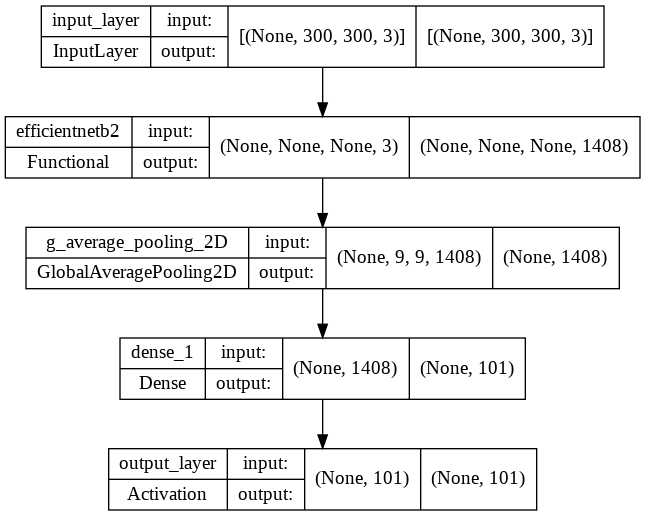

In [ ]:
# plot the model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

## Training and Evaluating the Model

### Training & Evaluation

Training the model is simple as we are not using [Gradient Tape](https://www.google.com/url?client=internal-element-cse&cx=016807462989910793636:iigazrvgr1m&q=https://www.tensorflow.org/guide/autodiff&sa=U&ved=2ahUKEwimj9_2hM76AhUTaMAKHelyCCMQFnoECAkQAg&usg=AOvVaw0_4RuAtInTi4YzgM5bXl7R) to calculate our losses. But on the other hand we can't access the advance features of TensorFlow like directly accessing the individual gradients that are in the layer or in other words, easy optimization of the gradients on some selected part of the network architecture (through backpropagation). *Though, it really doesn't matter for this project.*

Training any model through [Sequential](https://www.google.com/url?client=internal-element-cse&cx=016807462989910793636:iigazrvgr1m&q=https://www.tensorflow.org/guide/keras/sequential_model&sa=U&ved=2ahUKEwisgcqlh876AhU5QvEDHWzLAv8QFnoECAEQAg&usg=AOvVaw24B_OKFPM-cOWA_8YZu-cb) or [Functional API](https://www.google.com/url?client=internal-element-cse&cx=016807462989910793636:iigazrvgr1m&q=https://www.tensorflow.org/guide/keras/functional&sa=U&ved=2ahUKEwjy5JK6h876AhXTiFwKHTEHBt0QFnoECAEQAg&usg=AOvVaw2p3PY-yqFgsH3D6teOtGEK) requires:
* Training Dataset for calculating losses and optimizing the gradients
* Test Dataset for Validation puposes
* Number of epochs to train for
* `steps_per_epoch` which usually needs to be equal to the number of batches but it can be changed depending on whether the *dataset is set to `repeat()` in the data pipiline*.
* `validation_steps` requires the user to tell how much test data should be used in each step for validation. *Doing a small bit would do just fine to estimate how our model is performing.*
* Callbacks *(that were initialized earlier)*

In [ ]:
# train the model
EPOCHS = 25
STEPS_PER_EPOCH = len(train_dataset)

training_history_1 = model.fit(train_dataset,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=dev_dataset,
                             validation_steps=int(0.1 * len(dev_dataset)),
                             callbacks=[callback_earlystopping, callback_reduce_lr]
                             )

Epoch 1/25
2368/2368 [==============================] - 254s 102ms/step - loss: 2.2137 - accuracy: 0.5656 - val_loss: 1.8702 - val_accuracy: 0.6408 - lr: 0.0100
Epoch 2/25
2368/2368 [==============================] - 242s 101ms/step - loss: 1.7600 - accuracy: 0.6583 - val_loss: 1.8525 - val_accuracy: 0.6582 - lr: 0.0100
Epoch 3/25
2367/2368 [============================>.] - ETA: 0s - loss: 1.5672 - accuracy: 0.6943
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
2368/2368 [==============================] - 241s 101ms/step - loss: 1.5672 - accuracy: 0.6943 - val_loss: 1.9309 - val_accuracy: 0.6752 - lr: 0.0100
Epoch 4/25
2368/2368 [==============================] - 242s 101ms/step - loss: 0.7703 - accuracy: 0.8145 - val_loss: 1.4313 - val_accuracy: 0.7093 - lr: 0.0025
Epoch 5/25
2367/2368 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.8402
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
2368/2368 [========

In [ ]:
model_results_1 = model.evaluate(dev_dataset)

790/790 [==============================] - 68s 86ms/step - loss: 1.3648 - accuracy: 0.7143


In [ ]:
# evaluation curves function
def plot_evaluation_curves(history):

    epochs = range(len(history.history['loss']))
    val_loss, val_accuracy = history.history["val_loss"], history.history["val_accuracy"]
    train_loss, train_accuracy = history.history["loss"], history.history["accuracy"]

    # plot loss curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot accuracy curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

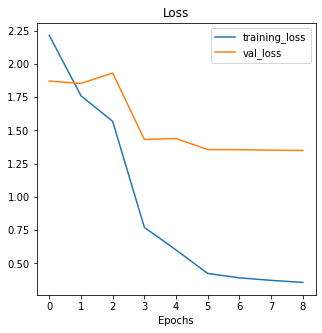

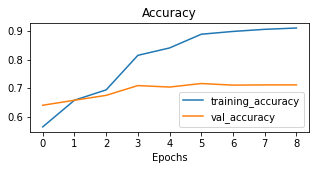

In [ ]:
# plot evaluation curves
plot_evaluation_curves(training_history_1)

### Conclusion

The model's `training_accuracy` and `training_loss` have significantly but the same can't be said for the `val_accuracy` and `val_loss` due to the large different between the respective values. From the initial observation, the model doesn't seem to be performing badly but due to **overfitting**, it isn't generalizing well on `dev_dataset` showing only a `val_accuracy` of `0.71`.

### Saving the Model

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# saving the model from `training part-1`
save_model_path_1 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_1"
model.save(save_model_path_1)

## FineTuning the Model

It is by far the most important part of the training step.

From **Model Building** step, it is to be noted that we set the `feature_extractor.training = False`. The only purpose as the name suggests was to use this feature extractor for inference to train the ***custom top layers*** of the model that were defined in that step. The `Batch Normalization layers` of the feature extractor was also set for inference **explicitly** as that was the requirement from the documentation.

Fine-Tuning has the following steps involved:
* Set the `training` top n - layers of the feature extracter to `True` which was previously ***False***.
* Set the `callback_reduce_lr` to reduce the learning rate by a factor after the loss doesn't further decrease.
* Set up `callback_earlystopping` to stop when even reducing learning rate isn't being helpful which indicates that the model has reached the global minimum. This will also be helpful because when using large number of epochs.


In [ ]:
# loading the saved model as `model`
save_model_path_1 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_1"
model = tf.keras.models.load_model(save_model_path_1)

In [ ]:
# check the number of layers in the model
print(f"Total number of layers in the Model are {len(model.layers)}")

Total number of layers in the Model are 5


In [ ]:
# check if the model layers are set to training
for i, layer in enumerate(model.layers):

    print(f"The {i+1} layer is {layer.name, layer.trainable, layer.dtype_policy} \n")

The 1 layer is ('input_layer', True, <Policy "float32">) 

The 2 layer is ('efficientnetb2', False, <Policy "mixed_float16">) 

The 3 layer is ('g_average_pooling_2D', True, <Policy "mixed_float16">) 

The 4 layer is ('dense_2', True, <Policy "mixed_float16">) 

The 5 layer is ('output_layer', True, <Policy "float32">) 



Two important things can be noted:
* The mixed-precision by the `dtype_policy` attribute of the individual layer have been outputting `<Policy "mixed_float16">` that was later changed to default `<Policy "float32">` tensors *(to make the other calculations easier in TensorFlow)* by using a seperate activation layer at the end of the model.
* Every layer is trainable except the `'efficientnetv2-m'` which was deliberately set to **inference mode**.

In [ ]:
# total number of layers inside the feature extractor
print(f"Total number of layers in the Feature Extractor are {len(model.layers[1].layers)}")

Total number of layers in the Feature Extractor are 339


In [ ]:
# check the layers inside of the 'efficientnetv2-m' (feature_extractor)
for i, layer in enumerate(model.layers[1].layers):

    print(f"The {i+1} layer is {layer.name, layer.trainable, layer.dtype_policy} \n")

In [ ]:
# set the layers of feature extractor for training and visualize
model.layers[1].trainable = True

# for layer in loaded_model.layers[1].layers[:-15]:
#     layer.trainable = False

for i, layer in enumerate(model.layers[1].layers):

    print(f"The {i+1} layer is {layer.name, layer.trainable, layer.dtype_policy} \n")

### Training & Evaluation

Now, the important thing before fine-tuning the model is to **compile the model** and to lower the `learning_rate to 0.0005`.

In [ ]:
# Reinitializing the optimizer
optimizer = optimizers.Adam(learning_rate=0.0005)

# Compile the model
model.compile(
          loss=sparse_categorical_loss,
          optimizer=optimizer,
          metrics=["accuracy"]
          )

In [ ]:
# model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 g_average_pooling_2D (Globa  (None, 1408)             0         
 lAveragePooling2D)                                              
                                                                 
 dense_2 (Dense)             (None, 101)               142309    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 7,910,878
Trainable params: 7,843,303
Non-trainable params: 67,575
____________________________________________

In [ ]:
# train the loaded_model (fine-tuning)
EPOCHS = 10
STEPS_PER_EPOCH = len(train_dataset)

fineTune_history_1 = model.fit(train_dataset,
                               epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_data=dev_dataset,
                               validation_steps=int(0.1 * len(dev_dataset)),
                               callbacks=[callback_earlystopping, callback_reduce_lr]
                               )

Epoch 1/10
2368/2368 [==============================] - 736s 297ms/step - loss: 1.2779 - accuracy: 0.6660 - val_loss: 0.9318 - val_accuracy: 0.7516 - lr: 5.0000e-04
Epoch 2/10
2368/2368 [==============================] - 703s 295ms/step - loss: 0.8782 - accuracy: 0.7584 - val_loss: 0.8816 - val_accuracy: 0.7555 - lr: 5.0000e-04
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.8003
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2368/2368 [==============================] - 703s 295ms/step - loss: 0.7011 - accuracy: 0.8003 - val_loss: 0.8882 - val_accuracy: 0.7642 - lr: 5.0000e-04
Epoch 4/10
2368/2368 [==============================] - 702s 295ms/step - loss: 0.2083 - accuracy: 0.9387 - val_loss: 0.6267 - val_accuracy: 0.8588 - lr: 1.2500e-04
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9799
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
236

In [ ]:
# evaluate the results
model_results_2 = model.evaluate(dev_dataset)

790/790 [==============================] - 72s 91ms/step - loss: 0.6749 - accuracy: 0.8413


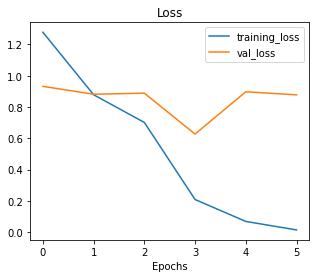

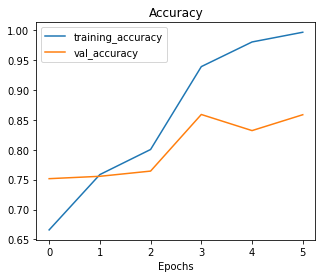

In [ ]:
# plot evaluation curves
plot_evaluation_curves(fineTune_history_1)

### Conslusion

`ReduceLROnPlateau` callback seems to have played a huge part in improving the `val_accuracy` and `val_loss` but in the last two epochs the model got degraded and it have shown **extreme overfitting** i.e. `training_accuracy` of `0.99`.
Fortunately, `EarlyStopping` callback has restored the model's best weights i.e. from the **4th epoch** *(third last epoch)*.

### Saving the Model

In [ ]:
# save the fine-tuned model
save_model_path_2 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_2"
model.save(save_model_path_2)

## Data Augmentation Experiment *(Solution to Overfitting?)*

There are many ways to overcome the overfitting but the easiest way to do that is to just perform data augmentation.

The data augmentation for this dataset will have three steps.
* Preparing the data augmentation model with TensorFlow's `Sequential API`.
* Creating an input layer for the `data_aug` model.
* Initializing `RandomFlip()` that will randomly horizontaly and vertically flip the images.
* Initializing `RandomRotation()` that will randomly rotate the images with a factor of `0.2`.
* Initializing `RandomZoom()` that will randomly zoom the image according to the initialized parameters.
* `data_aug` model will output the image with the shape of `(300, 300, 3)` to match the **model's** input.
* The `data_aug` model will then be passed to a new Sequential model `model_aug` as the first layer and the `model` will act as the second layer.

In [ ]:
# load the fine-tuned model as `model`
model = tf.keras.models.load_model("/content/drive/MyDrive/V2/saved_model_2")

### Model Building *(with augmentation layers)*

In [ ]:
# create randomflipping and randomRotation for images of the train_dataset
data_aug = tf.keras.Sequential([
                        layers.Input(shape=[300, 300, 3]),
                        layers.RandomFlip("horizontal_and_vertical"),
                        layers.RandomRotation(0.2),
                        layers.RandomZoom(0.1, 0.1)
                      ])

In [ ]:
# check `data_aug` model summary
data_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 300, 300, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 300, 300, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 300, 300, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# create new model as model_aug
model_aug = tf.keras.Sequential(
    [
        data_aug,   # data augmentation layers
        model    # previously trained model
    ]
)

# Reinitializing the optimizer
optimizer = optimizers.Adam(learning_rate=0.0005)

# Compile the model
model_aug.compile(
              loss=sparse_categorical_loss,
              optimizer=optimizer,
              metrics=["accuracy"]
              )

In [ ]:
# build the model and check model summary
model_aug.build((None, 300, 300, 3))
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 model_2 (Functional)        (None, 101)               7910878   
                                                                 
Total params: 7,910,878
Trainable params: 7,843,303
Non-trainable params: 67,575
_________________________________________________________________


### Training & Evaluation

In [ ]:
# train the model_aug with train_dataset
EPOCHS = 10
STEPS_PER_EPOCH = len(train_dataset)

aug_fineTune_history_1 =   model_aug.fit(train_dataset,
                                         epochs=EPOCHS,
                                         steps_per_epoch=STEPS_PER_EPOCH,
                                         validation_data=dev_dataset,
                                         validation_steps=int(0.1 * len(dev_dataset)),
                                         callbacks=[callback_earlystopping, callback_reduce_lr]
                                        )

Epoch 1/10
2368/2368 [==============================] - 750s 303ms/step - loss: 0.9864 - accuracy: 0.7289 - val_loss: 0.8468 - val_accuracy: 0.7603 - lr: 5.0000e-04
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.7528
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2368/2368 [==============================] - 711s 299ms/step - loss: 0.8929 - accuracy: 0.7528 - val_loss: 0.9468 - val_accuracy: 0.7417 - lr: 5.0000e-04
Epoch 3/10
2368/2368 [==============================] - 707s 297ms/step - loss: 0.4599 - accuracy: 0.8671 - val_loss: 0.6879 - val_accuracy: 0.8196 - lr: 1.2500e-04
Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8990
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
2368/2368 [==============================] - 709s 298ms/step - loss: 0.3350 - accuracy: 0.8990 - val_loss: 0.8111 - val_accuracy: 0.7979 - lr: 1.2500e-04
Epoch 5/10
236

In [ ]:
save_model_path_3 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_3"
model_aug.save(save_model_path_3)

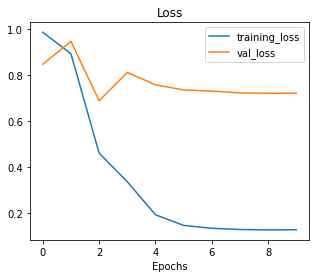

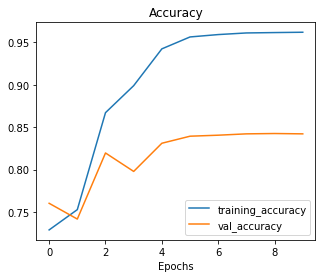

In [ ]:
plot_evaluation_curves(aug_fineTune_history_1)

In [ ]:
# evaluate the model without the augmentation layers
model_results_3 = model_aug.layers[1].evaluate(dev_dataset)   # `model_aug` has the first layer for the augmentation, so second layer is choosen (index: 1)

790/790 [==============================] - 70s 89ms/step - loss: 0.7686 - accuracy: 0.8346


### Conclusion

Unfortunately, no difference could been seen when using data augmentation. This can only mean one of the two things.

*   Complex data augmentation was lacking.
*   The feature extraction from the `training_dataset` seems to have reached the limit and won't be improving further by data augmentation.



## Choosing the Best Performing Model

There had been unexpected results from the model training with data augmentation from the previous section which lead to ambiguity between choosing the *fine-tuned model* and *model trained with additional augmented data*.

There will be a set of tests that will be performed in order to evaluate these two models.


### Evaluation of Fine Tuned Model

In [ ]:
# load the fine-tuned model
save_model_path_2 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_2"
fineTuned_model = tf.keras.models.load_model(save_model_path_2)

# check model summary
fineTuned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 g_average_pooling_2D (Globa  (None, 1408)             0         
 lAveragePooling2D)                                              
                                                                 
 dense_2 (Dense)             (None, 101)               142309    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 7,910,878
Trainable params: 7,843,303
Non-trainable params: 67,575
____________________________________________

In [35]:
# get true labels from dev_dataset for evaluation
y_labels = [label.numpy() for _, label in dev_dataset.unbatch()]
print(y_labels[:5])

[29, 81, 91, 53, 97]


In [36]:
# get pred labels from final_model for evaluation
fineTuned_pred_labels = fineTuned_model.predict(dev_dataset, verbose=1)

790/790 [==============================] - 76s 93ms/step


In [40]:
# get the index with the highest value
fineTuned_pred_labels = tf.argmax(fineTuned_pred_labels, axis=1)

In [ ]:
fineTuned_pred_labels[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([29, 81, 91, 53, 97])>

In [55]:
# function to create the data frame for predictions
def df_for_evaluation(y_labels, pred_labels):

    # create data frame for model's predictions
    df = pd.DataFrame({"true_labels": y_labels,
                       "predicted_labels": pred_labels})
    
    # `match` column that will that if the true and predicted labels are the same
    df["match"] = (df.true_labels.values == df.predicted_labels.values)

    # replace the ordinal-encoded labels with the category names
    dict_to_replace = {i: n for i, n in enumerate(class_names)}
    df["true_labels"].replace(dict_to_replace, inplace=True)
    df["predicted_labels"].replace(dict_to_replace, inplace=True)

    # convert `match` column's dtype to int
    # df = df.astype({"match": np.int64})

    return df

In [56]:
# create data frame for fine-tuned model's predictions
fineTuned_df = df_for_evaluation(y_labels, fineTuned_pred_labels)

fineTuned_df.head(5)

true_labels     predicted_labels  match
0            cup_cakes            cup_cakes   True
1                ramen                ramen   True
2  spaghetti_carbonara  spaghetti_carbonara   True
3            hamburger            hamburger   True
4             takoyaki             takoyaki   True

In [ ]:
# Accuracy of the fineTuned_model
fineTuned_model_accuracy = fineTuned_df.match.value_counts(normalize=True)[1]
print(f"The accuracy of the `fineTuned_model` is {fineTuned_model_accuracy}")

The accuracy of the `fineTuned_model` is 0.8413465346534653


In [ ]:
# plot the fineTuned_df's `match` column
fig = px.bar(
    data_frame=fineTuned_df.match.value_counts(normalize=True),
    title="Fine-Tuned Model's Predictions",
    width=500,
    height=400
)

fig.update_layout(xaxis_title="Predictions", yaxis_title="Count", showlegend=False)
fig.show()

In [63]:
from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, fineTuned_pred_labels, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

fineTuned_f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=True)
fineTuned_f1_scores.head()

class_name  f1_score
93             steak  0.585551
77         pork_chop  0.624230
22  chocolate_mousse  0.651261
0          apple_pie  0.663830
8      bread_pudding  0.665392

In [75]:
# plot the top-10 most wrong predictions
fig = px.bar(
    y=fineTuned_f1_scores.head(10).class_name,
    x=fineTuned_f1_scores.head(10).f1_score,
    title="Top-10 Most Wrong Predictions",
    width=800,
    height=400,
    orientation="h"
)
fig.update_layout(
    xaxis_title="F1-Score",
    yaxis_title="Classes",
    showlegend=False
)
fig.show()

The cell below was copied from the [source](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  plt.title("Confusion Matrix", fontsize=40)
  plt.xlabel("Predicted label", fontsize=40)
  plt.ylabel("True label", fontsize=40)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

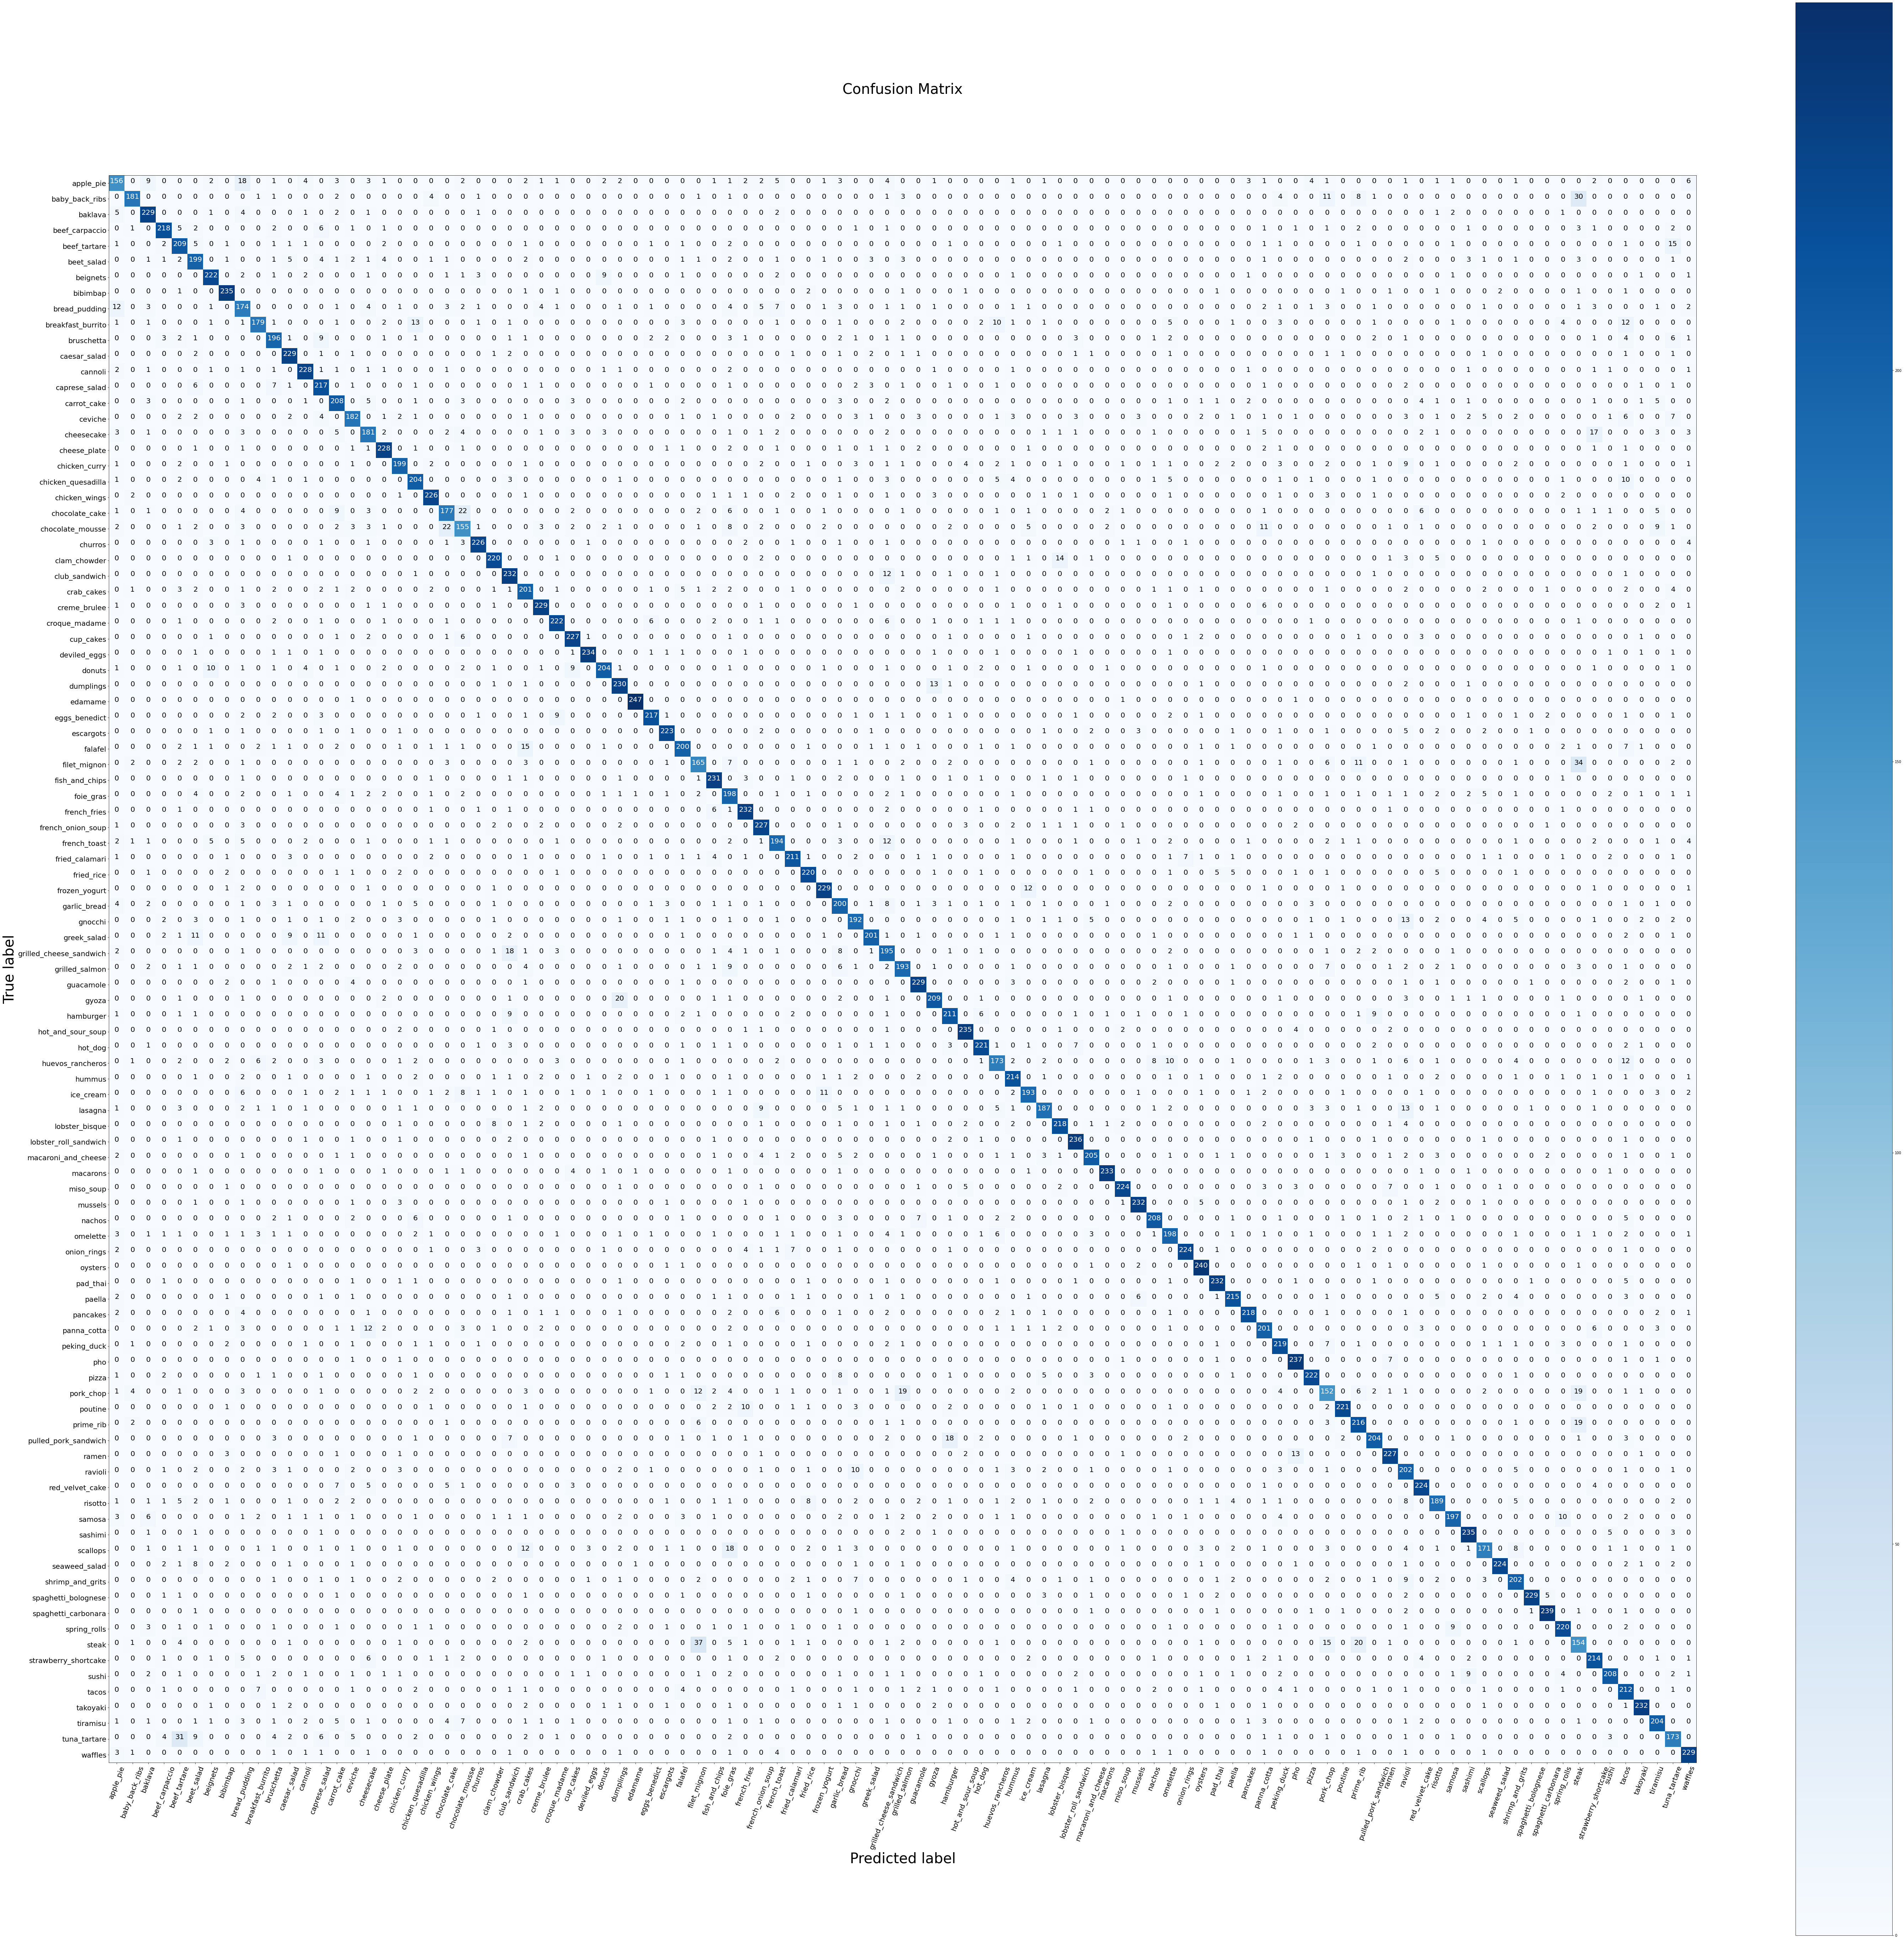

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=fineTuned_pred_labels,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

### Evaluation of Fine Tuned Model *(trained with augmented data)*

In [66]:
# load the fine-tuned model
save_model_path_3 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_3"
model_aug = tf.keras.models.load_model(save_model_path_3)

# check model summary
model_aug.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 g_average_pooling_2D (Globa  (None, 1408)             0         
 lAveragePooling2D)                                              
                                                                 
 dense_2 (Dense)             (None, 101)               142309    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 7,910,878
Trainable params: 7,843,303
Non-trainable params: 67,575
____________________________________________

In [67]:
# get pred labels from model_aug for evaluation
fineTuned_aug_pred_labels = model_aug.predict(dev_dataset, verbose=1)

790/790 [==============================] - 81s 100ms/step


In [68]:
# get the index with the highest value
fineTuned_aug_pred_labels = tf.argmax(fineTuned_aug_pred_labels, axis=1)

In [ ]:
# create data frame for `model_aug` predictions
aug_df = df_for_evaluation(y_labels, fineTuned_aug_pred_labels)

aug_df.head(5)

true_labels     predicted_labels  match
0            cup_cakes            cup_cakes   True
1                ramen                ramen   True
2  spaghetti_carbonara  spaghetti_carbonara   True
3            hamburger            hamburger   True
4             takoyaki             takoyaki   True

In [ ]:
# Accuracy of the fineTuned_model
fineTuned_aug_model_accuracy = aug_df.match.value_counts(normalize=True)[1]
print(f"The accuracy of the `fineTuned_model is `{fineTuned_aug_model_accuracy}")

The accuracy of the `fineTuned_model is `0.8346534653465346


In [ ]:
# plot the fineTuned_df's `match` column
fig = px.bar(
    data_frame=aug_df.match.value_counts(normalize=True),
    title="Fine-Tuned Model's Predictions",
    width=500,
    height=400
)

fig.update_layout(xaxis_title="Predictions", yaxis_title="Count", showlegend=False)
fig.show()

But the accuracy doesn't let us see the whole picture of what's going on with the predictions until unless we generate a `classification_report`.

**Classification Report** from **Scikit Learn** is able to generate the *precision*, *recall* and *f1-score* of the individual classes showing the results of how well these classes have been predicted.

In [69]:
from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, fineTuned_aug_pred_labels, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

fineTuned_aug_f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=True)
fineTuned_aug_f1_scores.head()

class_name  f1_score
93             steak  0.529183
77         pork_chop  0.599206
37      filet_mignon  0.617424
22  chocolate_mousse  0.628352
21    chocolate_cake  0.654424

In [71]:
# plot the top-10 most wrong predictions
fig = px.bar(
    y=fineTuned_aug_f1_scores.head(10).class_name,
    x=fineTuned_aug_f1_scores.head(10).f1_score,
    title="Top-10 Most Wrong Predictions",
    width=800,
    height=400,
    orientation="h"
)
fig.update_layout(
    xaxis_title="F1-Score",
    yaxis_title="Classes",
    showlegend=False
)
fig.show()

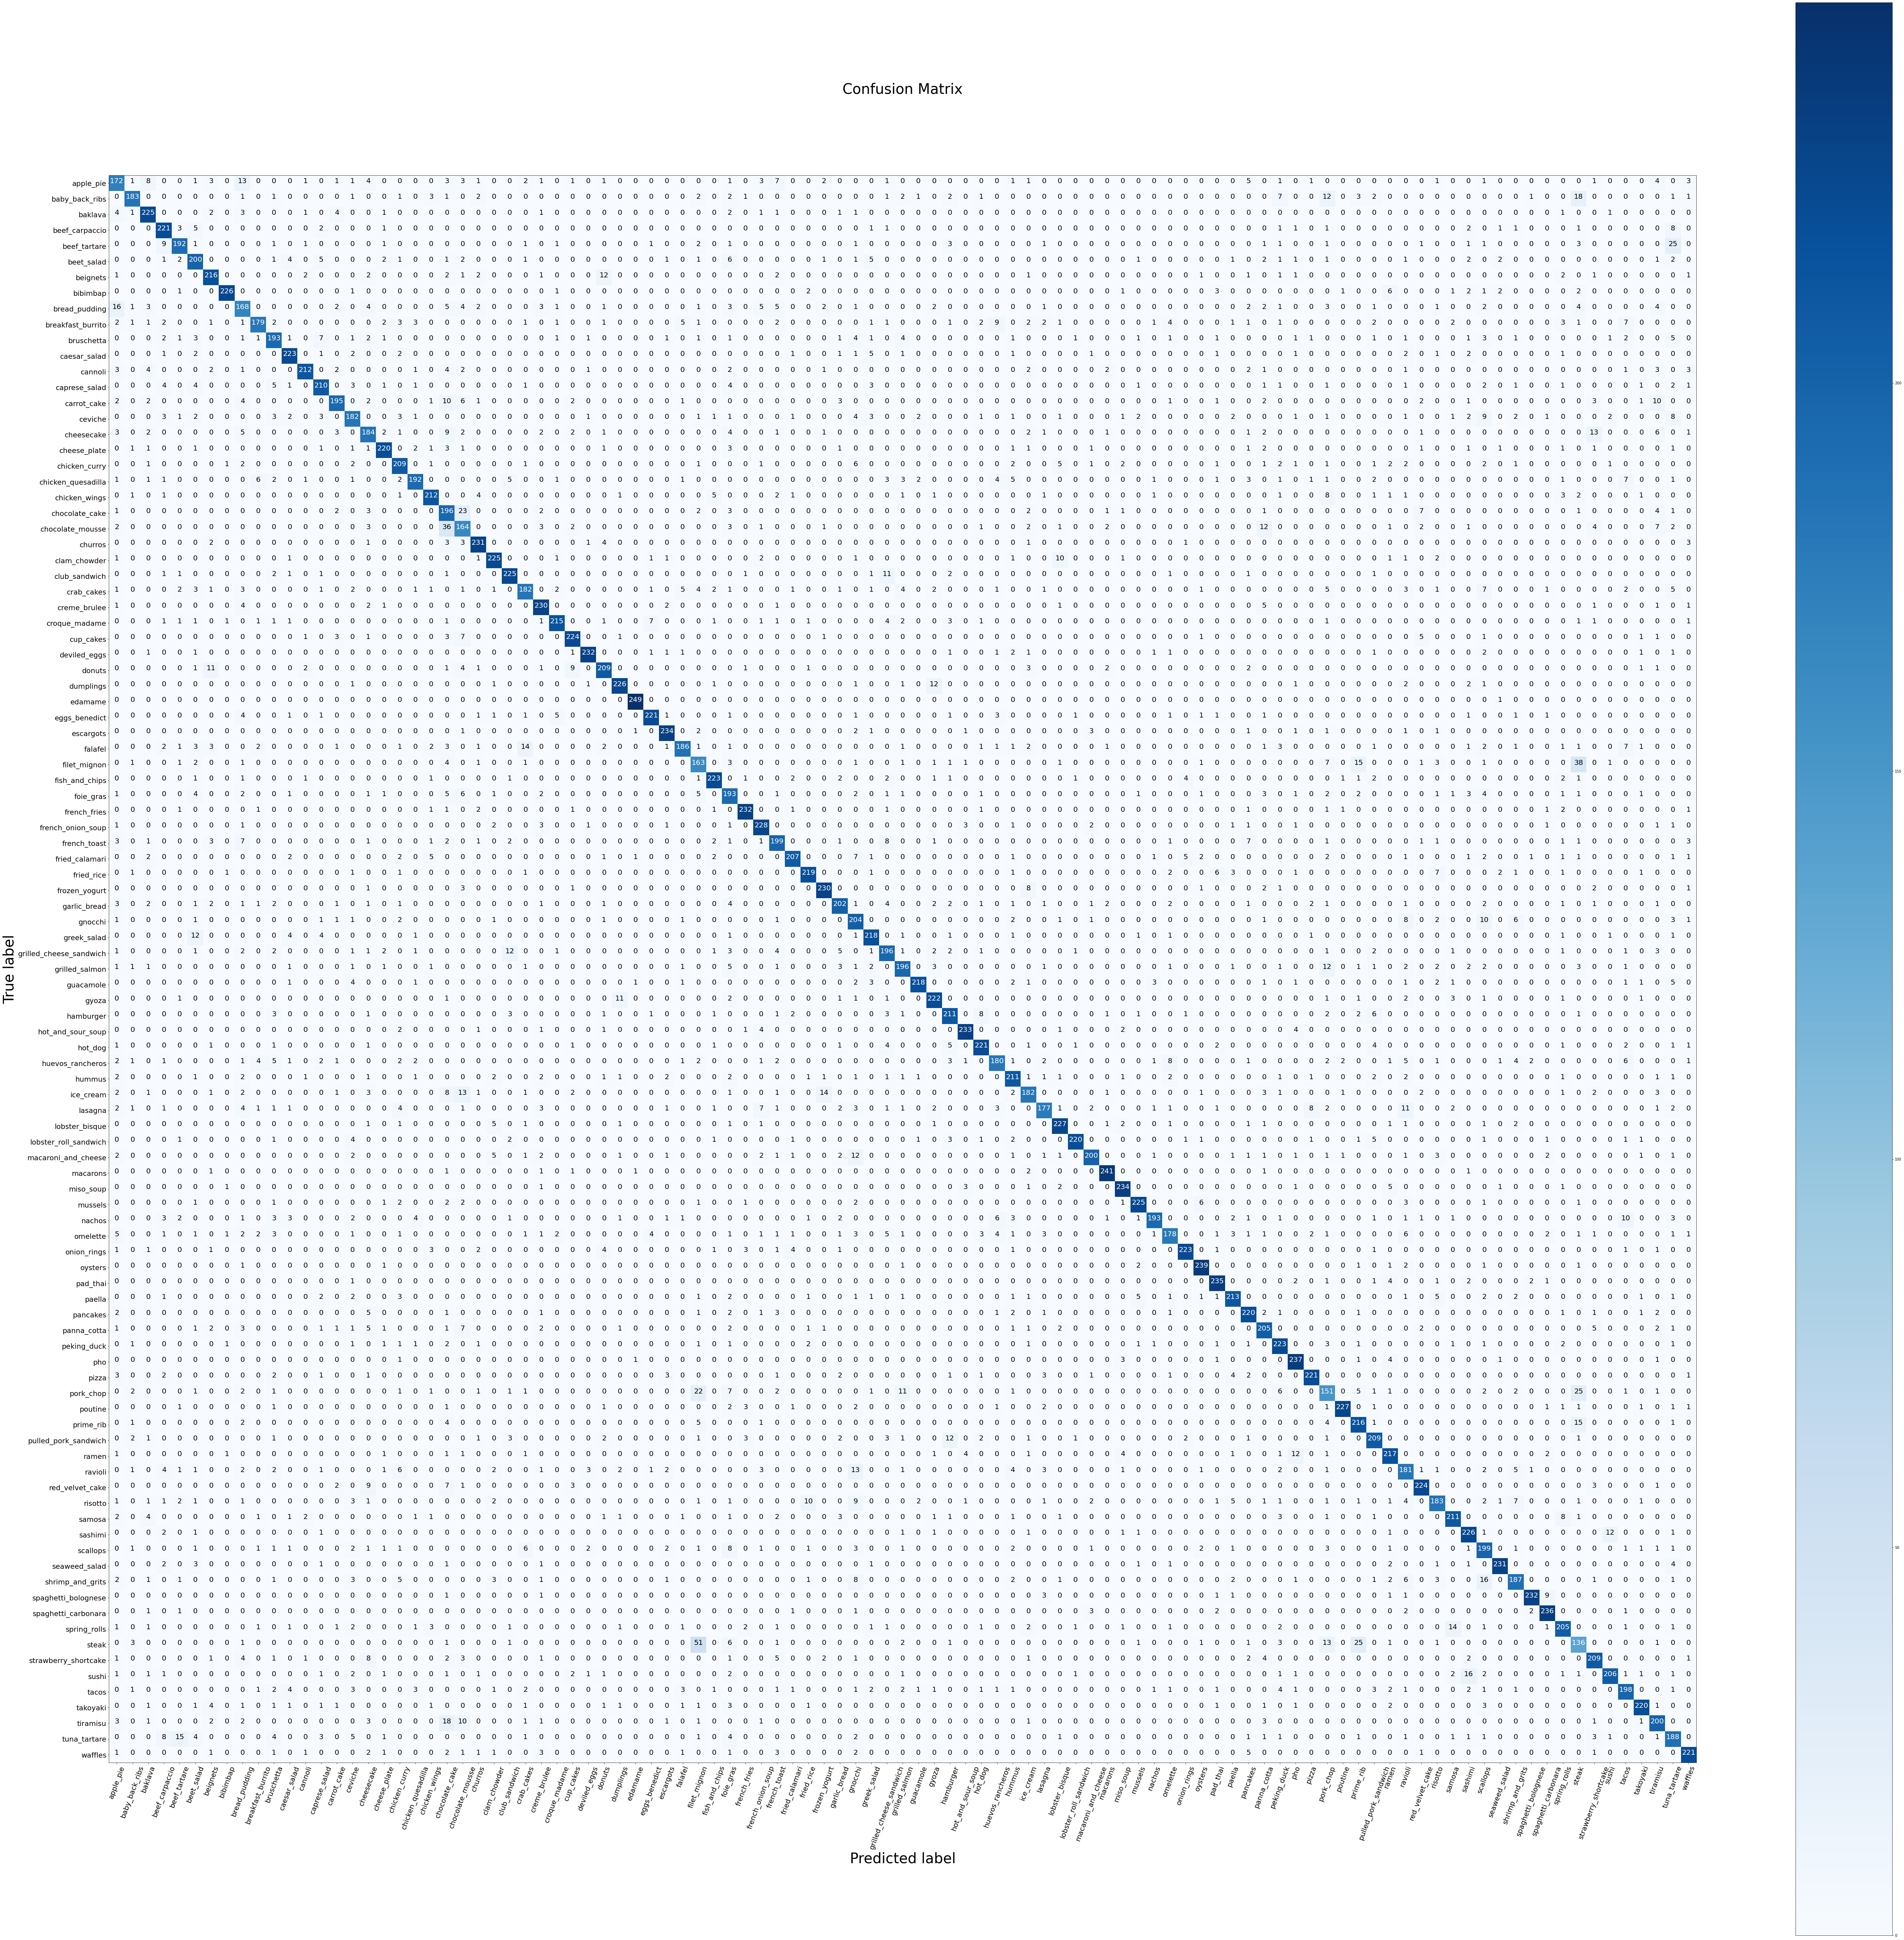

In [ ]:
# plot confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=fineTuned_aug_pred_labels,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

### Comparison between the two Models

There are several key-points that were taken note of regarding the evaluation of the above two models.

First, both the models accuracy are pretty much the same.

In [ ]:
# plot both models accuracy
x = ["Fine-Tuned Model (No Data Augmentation)", "Fine-Tuned Model (Data Augmentation)"]
y = [round(fineTuned_model_accuracy*100, 2), round(fineTuned_aug_model_accuracy*100, 2)]

fig = px.bar(
    x=x,
    y=y,
    title="Fine-Tuned Models' Accuracy Comparison",
    width=500,
    height=700
)

fig.update_layout(xaxis_title="Models", yaxis_title="Accuracy (%)", showlegend=False)
fig.show()

Both the models accuracy are pretty much the same. *But is that really the case?*

In [72]:
# print the top-10 most wrong predictions for the two models
print(f"The most wrong predictions for fine-tuned model are:\n{fineTuned_f1_scores.head(10).class_name.to_list()}\n\n")
print(f"The most wrong predictions for fine-tuned model trained with augmented data are:\n{fineTuned_aug_f1_scores.head(10).class_name.to_list()}")

The most wrong predictions for fine-tuned model are:
['steak', 'pork_chop', 'chocolate_mousse', 'apple_pie', 'bread_pudding', 'filet_mignon', 'foie_gras', 'tuna_tartare', 'ravioli', 'grilled_cheese_sandwich']


The most wrong predictions for fine-tuned model trained with augmented data are:
['steak', 'pork_chop', 'filet_mignon', 'chocolate_mousse', 'chocolate_cake', 'bread_pudding', 'apple_pie', 'foie_gras', 'tuna_tartare', 'ravioli']


In [73]:
# the difference between the two models (fineTuned_model wrong predictions)
print(f"fineTuned_model most wrong predictions (not in model_aug): {set(fineTuned_f1_scores.head(10).class_name.to_list()).difference(set(fineTuned_aug_f1_scores.head(10).class_name.to_list()))}")

fineTuned_model most wrong predictions (not in model_aug): {'grilled_cheese_sandwich'}


In [74]:
# the difference between the two models (model_aug wrong predictions)
print(f"model_aug most wrong predictions (not in fineTuned_model): {set(fineTuned_aug_f1_scores.head(10).class_name.to_list()).difference(set(fineTuned_f1_scores.head(10).class_name.to_list()))}")

model_aug most wrong predictions (not in fineTuned_model): {'chocolate_cake'}


Second, the most-wrong predictions are not the same for the two models.

From the above set, it can interpreted that data augmentation wasn't totally useless. It was actually able to correctly predict `{"grilled_cheese_sandwich"}` which the simple fine-tuning wasn't able to. Though, data augmentation also created a issue by predicting `{"chocolate_cake"}` wrongly which the simple fine-tuned model was correctly predicting.

### Conclusion

There is a temptation to use **fine-tuned model trained with augmented dataset** as it may be more robust and may generalize well when in production. Unfortunately, it hasn't shown overall improvement despite having shown improvement on some of the categories.

So, the simple `fineTuned_model` would be considered as the final model.

## The Final Model

As the `fineTuned_model` was chosen as the final model, now it's time to make some predictions on the test images.

In [10]:
# load the fine-tuned model
save_model_path_2 = "/content/drive/MyDrive/Portfolio/Food101/V2/saved_model_2"
fineTuned_model = tf.keras.models.load_model(save_model_path_2)

# check model summary
fineTuned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 g_average_pooling_2D (Globa  (None, 1408)             0         
 lAveragePooling2D)                                              
                                                                 
 dense_2 (Dense)             (None, 101)               142309    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 7,910,878
Trainable params: 7,843,303
Non-trainable params: 67,575
____________________________________________

In [20]:
# list the test_imgs folder contents
path = "/content/drive/MyDrive/Portfolio/Food101/V2/test_imgs/"
test_imgs = os.listdir(path)
full_paths = [path + name for name in test_imgs]
full_paths

['/content/drive/MyDrive/V2/test_imgs/french_onion_soup.jpg',
 '/content/drive/MyDrive/V2/test_imgs/french_fries.jpg',
 '/content/drive/MyDrive/V2/test_imgs/french_toast.jpg',
 '/content/drive/MyDrive/V2/test_imgs/fried_calamari.jpg',
 '/content/drive/MyDrive/V2/test_imgs/fried_rice.jpg',
 '/content/drive/MyDrive/V2/test_imgs/frozen_yogurt.jpg',
 '/content/drive/MyDrive/V2/test_imgs/garlic_bread.jfif',
 '/content/drive/MyDrive/V2/test_imgs/gnocchi.jpg',
 '/content/drive/MyDrive/V2/test_imgs/greek_salad.jfif',
 '/content/drive/MyDrive/V2/test_imgs/grilled_cheese_sandwich.jfif']

In [30]:
# preprocess function for test_imgs predictions
def preprocess_test_imgs(paths, shape=300):
    imgs_paths = paths
    imgs_tensors = []
    for path in paths:
        # Read in the image
        img = tf.io.read_file(path)
        # Decode it into a tensor
        img = tf.io.decode_image(img)
        # Resize the image
        img = tf.image.resize(img, [shape, shape])

        imgs_tensors.append(img)

    return imgs_tensors

In [31]:
# generate test_imgs tensors
imgs_tensors = preprocess_test_imgs(full_paths)
imgs_tensors[0]

<tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
array([[[193.72333   , 175.78      , 153.75166   ],
        [199.09001   , 185.575     , 167.84      ],
        [206.55832   , 193.55832   , 174.55832   ],
        ...,
        [ 27.516748  ,   0.66674805,   0.        ],
        [ 28.400146  ,   0.8000488 ,   0.        ],
        [ 25.        ,   1.        ,   1.        ]],

       [[199.89665   , 184.89665   , 161.89665   ],
        [205.475     , 188.475     , 168.875     ],
        [194.44165   , 179.07498   , 158.28331   ],
        ...,
        [ 29.483393  ,   0.51660806,   0.        ],
        [ 29.724998  ,   0.27500057,   0.        ],
        [ 26.449999  ,   1.        ,   1.7249994 ]],

       [[205.94167   , 190.31667   , 174.19167   ],
        [179.675     , 167.77501   , 149.90001   ],
        [205.33333   , 192.5       , 170.91667   ],
        ...,
        [ 29.333252  ,   0.        ,   0.        ],
        [ 28.        ,   0.        ,   0.        ],
        [ 26.75   

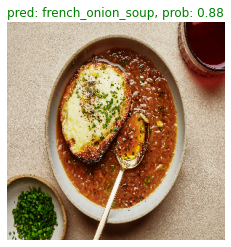

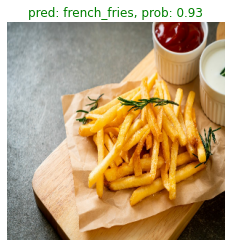

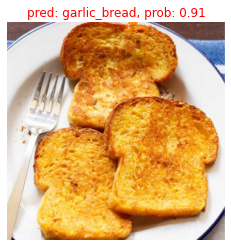

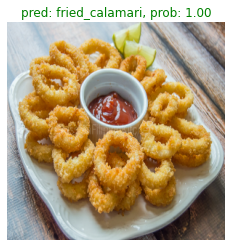

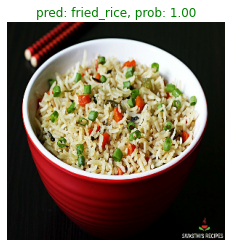

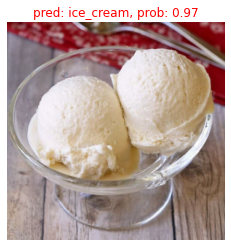

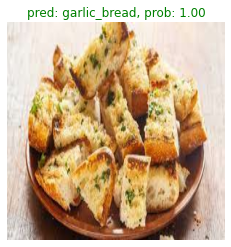

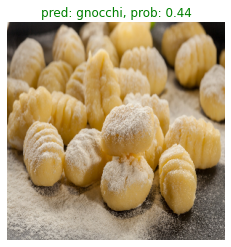

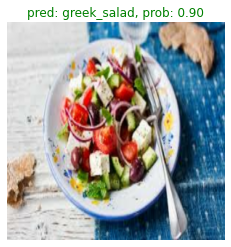

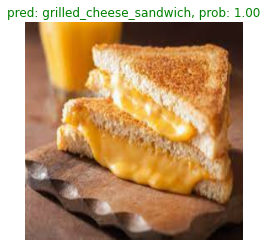

In [79]:
# perform predictions on custom images
for i, img in enumerate(imgs_tensors):
  pred_prob = fineTuned_model.predict(tf.expand_dims(img, axis=0), verbose=0) # make prediction on image with shape [None, 300, 300, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label

  # change the title color
  if pred_class in test_imgs[i]:
      plt.rcParams.update({'text.color': "green"}) # if prediction is correct then the title color will be green
  else:
      plt.rcParams.update({'text.color': "red"})  # if prediction is wrong then the title color will be red
      
  # Plot the image
  plt.figure()
  plt.imshow(img/255.) # normalizing the image tensors
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## Deployment

**That's all for this Project!**

**The following deployment section will be done seperately from this notebook.**